# Research note
step 2: fit the sharpness

somthing to note
- what does the sharpness of the edge tells about the precison of the scaling relations?
perturb the scaling relations to see which amount of perturbation could match the observed sharpness.

1. account for metallicity effect, maybe separate into different bins?

2. make strips

- what does the location of the edge tells about the power dependencies in the scaling relations?
fit the two distributions.


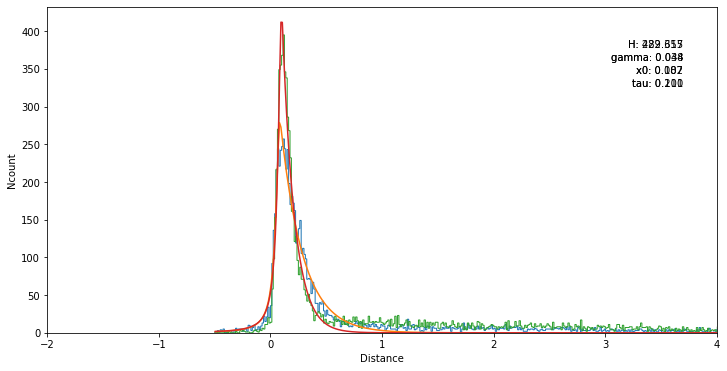

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
from lib.histdist import model1, distfit # import distfit

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
### 1 observation
dist = np.load("sample/obs/nike_dist.npy")
bins = np.linspace(-0.5, 12, 1000)
obj = distfit(dist, bins, model1())
obj.fit()
obj.plot_fit(ax=ax)

### 2 model
dist = np.load("sample/padova/nike_dist.npy")
bins = np.linspace(-0.5, 12, 1000)
obj = distfit(dist, bins, model1())
obj.fit()
obj.plot_fit(ax=ax)